In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,fbeta_score
from sklearn.metrics import log_loss
from sklearn import metrics

from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC

from IPython.display import Image  
from six import StringIO  
import graphviz
import pydot

In [2]:
ccdata = pd.read_csv('BankChurners.csv')

In [3]:
#run once
ccdata.drop("CLIENTNUM",axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',axis=1,inplace=True)
#run once
ccdata['Gender'].replace({'M':1,'F':0},inplace=True)
ccdata["Attrition_Flag"].replace({'Existing Customer':0,'Attrited Customer':1},inplace=True)

In [4]:
def objdata(dataset):
    for col in dataset:
        if dataset[col].dtypes=='object':
            print(f'{col}: {dataset[col].unique()}: {dataset[col].dtype} : count={dataset[col].count()}')
            
def othdata(dataset):
    for col in dataset:
        if dataset[col].dtypes!='object':
            print(f'{col}: {dataset[col].unique()}: {dataset[col].dtype} : count={dataset[col].count()}')

In [5]:
objdata(ccdata)

Education_Level: ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']: object : count=10127
Marital_Status: ['Married' 'Single' 'Unknown' 'Divorced']: object : count=10127
Income_Category: ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']: object : count=10127
Card_Category: ['Blue' 'Gold' 'Silver' 'Platinum']: object : count=10127


In [6]:
#run once
#drop_first = True to avoid structural multicollinearity
ccdata2 = pd.get_dummies(data=ccdata,columns=['Education_Level','Marital_Status',"Income_Category",'Card_Category'],drop_first=True)
ccdata2.columns
ccdata2.drop(['Avg_Open_To_Buy','Customer_Age','Total_Trans_Ct','Months_on_book','Total_Amt_Chng_Q4_Q1'],axis=1,inplace=True)

In [7]:
X = ccdata2.drop("Attrition_Flag",axis=1)
y = ccdata2['Attrition_Flag']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

## hyperparameter optimization

In [8]:
r_xgb = XGBClassifier(use_label_encoder=False)

In [11]:
from sklearn.model_selection import GridSearchCV
#round1
parameter_grid = [
    {
        'objective':['binary:logistic','binary:logitraw','binary:hinge','count:poisson'],
        'max_depth':np.arange(5,30,5),
        'learning_rate':[0.01,0.05,0.1],
        'gamma':[0.1,0.25,1],
        'reg_lambda':[0,1,10]
    }
]

clf = GridSearchCV(r_xgb, param_grid = parameter_grid, cv = 5, verbose=True, n_jobs = -1)

In [12]:
best_clf = clf.fit(X_train,y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[19:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
rawresults = pd.DataFrame(clf.cv_results_)
#rawresults

In [14]:
best_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [15]:
best_clf.best_score_

0.9428609679162856

## modelling

In [8]:
from xgboostmodule import xgboost,xgboost_rebalanced

xgboostmodule.py is being imported into another module


In [9]:
y_test

7403    0
2005    1
8270    0
646     0
1690    0
       ..
5950    0
3434    0
9023    0
6599    0
8523    0
Name: Attrition_Flag, Length: 3039, dtype: int64

In [10]:
xgb1 = xgboost(X_train,X_test,y_train,y_test)

[17:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [11]:
xgb2 = xgboost_rebalanced(X_train,X_test,y_train,y_test)

[17:17:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [36]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm, y_sm = smote.fit_resample(X_train,y_train)

print(y_sm.value_counts())
#generate train test split first then do resampling only on training set

##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train3, y_train3 = pipeline.fit_resample(X_train,y_train)
print(y_train3.value_counts())

1    5949
0    5949
Name: Attrition_Flag, dtype: int64
0    3965
1    2379
Name: Attrition_Flag, dtype: int64


In [13]:
xgb3 = xgboost(X_sm,X_test,y_sm,y_test)
xgb4 = xgboost_rebalanced(X_sm,X_test,y_sm,y_test)

xgb5 = xgboost(X_train3,X_test,y_train3,y_test)
xgb6 = xgboost_rebalanced(X_train3,X_test,y_train3,y_test)

[17:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [42]:
ls = [xgb1,xgb2,xgb3,xgb4,xgb5,xgb6]
[print('xgb{} f2 score: '.format(i+1),round(x.f2_score,3)) for i,x in enumerate(ls)]

xgb1 f2 score:  0.834
xgb2 f2 score:  0.867
xgb3 f2 score:  0.835
xgb4 f2 score:  0.835
xgb5 f2 score:  0.857
xgb6 f2 score:  0.871


[None, None, None, None, None, None]

## post feature selection

                     Feature_names  Importances    cumsum
0                  Total_Trans_Amt     0.115853  0.115853
1         Total_Relationship_Count     0.113925  0.229778
2                           Gender     0.108215  0.337993
3              Total_Revolving_Bal     0.097247  0.435240
4              Total_Ct_Chng_Q4_Q1     0.048541  0.483781
5           Marital_Status_Married     0.046304  0.530085
6         Education_Level_Graduate     0.033651  0.563736
7       Education_Level_Uneducated     0.032448  0.596184
8            Marital_Status_Single     0.031913  0.628097
9          Income_Category_Unknown     0.029904  0.658001
10  Income_Category_Less than $40K     0.029109  0.687110
11         Education_Level_Unknown     0.029062  0.716172
12          Marital_Status_Unknown     0.027513  0.743685
13          Months_Inactive_12_mon     0.027276  0.770961
14                    Credit_Limit     0.026979  0.797941
15           Avg_Utilization_Ratio     0.026935  0.824875
16     Educati

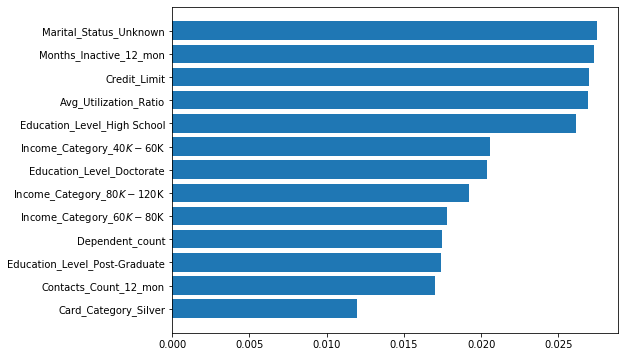

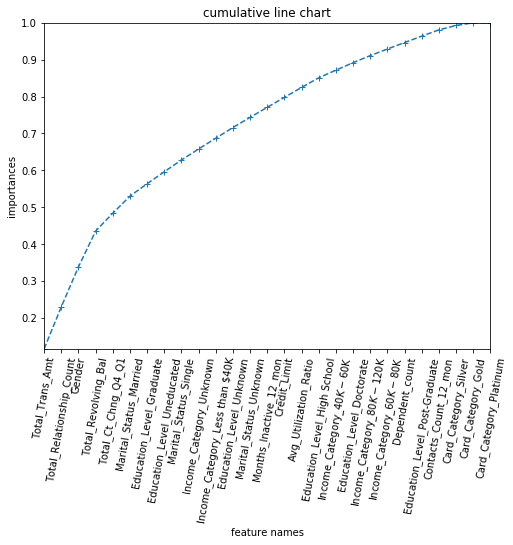

In [31]:
xgb1.feature_importance()

In [32]:
X_train2 = X_train.drop(['Education_Level_Post-Graduate','Contacts_Count_12_mon','Card_Category_Silver','Card_Category_Gold','Card_Category_Platinum'], axis = 1)
X_test2 = X_test.drop(['Education_Level_Post-Graduate','Contacts_Count_12_mon','Card_Category_Silver','Card_Category_Gold','Card_Category_Platinum'], axis = 1)

In [33]:
xgb7 = xgboost(X_train2,X_test2,y_train,y_test)
xgb8 = xgboost_rebalanced(X_train2,X_test2,y_train,y_test)

[17:27:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [35]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm2, y_sm2 = smote.fit_resample(X_train2,y_train)

print(y_sm2.value_counts())
#generate train test split first then do resampling only on training set

##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train4, y_train4 = pipeline.fit_resample(X_train2,y_train)
print(y_train4.value_counts())

1    5949
0    5949
Name: Attrition_Flag, dtype: int64
0    3965
1    2379
Name: Attrition_Flag, dtype: int64


In [37]:
xgb9 = xgboost(X_sm2,X_test2,y_sm2,y_test)
xgb10 = xgboost_rebalanced(X_sm2,X_test2,y_sm2,y_test)

xgb11 = xgboost(X_train4,X_test2,y_train4,y_test)
xgb12 = xgboost_rebalanced(X_train4,X_test2,y_train4,y_test)

[17:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [41]:
ls1 = [xgb7,xgb8,xgb9,xgb10,xgb11,xgb12]

[print('xgb{} f2 score:'.format(i+8),round(x.f2_score,3)) for i,x in enumerate(ls1)]

xgb8 f2 score: 0.822
xgb9 f2 score: 0.856
xgb10 f2 score: 0.828
xgb11 f2 score: 0.828
xgb12 f2 score: 0.85
xgb13 f2 score: 0.868


[None, None, None, None, None, None]

                     Feature_names  Importances    cumsum
0                  Total_Trans_Amt     0.131914  0.131914
1         Total_Relationship_Count     0.096318  0.228232
2                           Gender     0.094305  0.322537
3              Total_Revolving_Bal     0.089982  0.412520
4              Total_Ct_Chng_Q4_Q1     0.053247  0.465766
5           Marital_Status_Married     0.051134  0.516900
6            Avg_Utilization_Ratio     0.034434  0.551335
7          Education_Level_Unknown     0.032939  0.584274
8          Income_Category_Unknown     0.031307  0.615581
9         Education_Level_Graduate     0.031123  0.646703
10           Marital_Status_Single     0.029740  0.676443
11                    Credit_Limit     0.029474  0.705917
12          Months_Inactive_12_mon     0.029222  0.735139
13      Education_Level_Uneducated     0.027730  0.762869
14     Education_Level_High School     0.025828  0.788698
15       Education_Level_Doctorate     0.025794  0.814492
16  Income_Cat

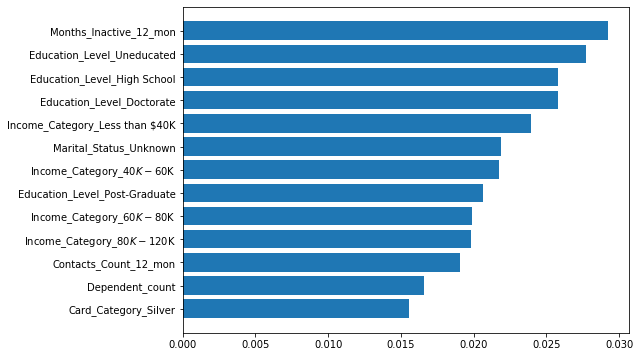

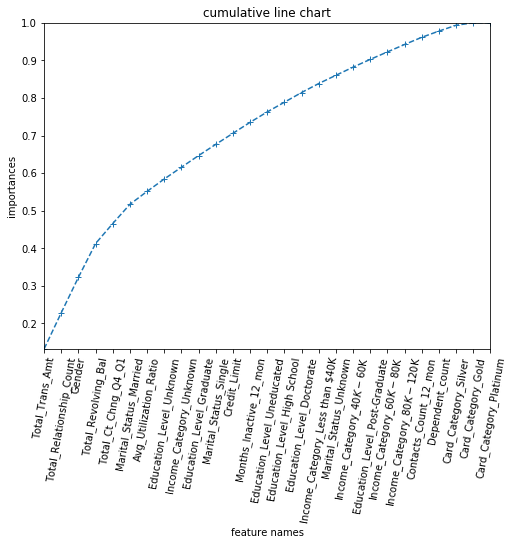

In [43]:
xgb6.feature_importance()